## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

### Data Load

In [2]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset.csv')

DI_train = pd.read_csv('../data/DI_train_dataset.csv')
DI_test = pd.read_csv('../data/DI_test_dataset.csv')

In [3]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

### 인코딩 

In [4]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "배란_유도_유형",
    "착상_전_유전_검사_사용_여부",
    "남성_주_불임_원인",
    "남성_부_불임_원인",
    "여성_주_불임_원인",
    "여성_부_불임_원인",
    "부부_주_불임_원인",
    "부부_부_불임_원인",
    "불명확_불임_원인",
    "불임_원인_-_난관_질환",
    "불임_원인_-_남성_요인",
    "불임_원인_-_배란_장애",
    "불임_원인_-_여성_요인",
    "불임_원인_-_자궁경부_문제",
    "불임_원인_-_자궁내막증",
    "불임_원인_-_정자_농도",
    "불임_원인_-_정자_면역학적_요인",
    "불임_원인_-_정자_운동성",
    "불임_원인_-_정자_형태",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "PGD_시술_여부",
    "PGS_시술_여부",
    "난자_채취_경과일",
    "난자_해동_경과일",
    "난자_혼합_경과일",
    "배아_이식_경과일",
    "배아_해동_경과일",
    "변환된_특정_시술_유형"
]

In [5]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "임신_시도_또는_마지막_임신_경과_연수",
    "총_시술_횟수",
    "클리닉_내_총_시술_횟수",
    "IVF_시술_횟수",
    "DI_시술_횟수",
    "총_임신_횟수",
    "IVF_임신_횟수",
    "DI_임신_횟수",
    "총_출산_횟수",
    "IVF_출산_횟수",
    "DI_출산_횟수",
    "정자_기증자_나이",
    "변환된_특정_시술_유형"
]

In [6]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

In [7]:
# import category_encoders as ce

# # 모든 범주형 변수를 문자열로 변환
# IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
# DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
# IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
# DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# # 타겟 인코더를 사용하여 범주형 변수 인코딩
# IVF_target_encoder = ce.TargetEncoder(cols=IVF_categorical_columns)
# DI_target_encoder = ce.TargetEncoder(cols=DI_categorical_columns)

# # 타겟 인코딩을 위해 타겟 변수가 필요합니다. 예시로 IVF_y와 DI_y를 사용합니다.
# IVF_X[IVF_categorical_columns] = IVF_target_encoder.fit_transform(IVF_X[IVF_categorical_columns], IVF_y)
# DI_X[DI_categorical_columns] = DI_target_encoder.fit_transform(DI_X[DI_categorical_columns], DI_y)
# IVF_test[IVF_categorical_columns] = IVF_target_encoder.transform(IVF_test[IVF_categorical_columns])
# DI_test[DI_categorical_columns] = DI_target_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [8]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

### DI 데이터

In [9]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[I 2025-02-03 21:39:10,781] A new study created in memory with name: no-name-d19abc3c-a3e7-4ca5-88fd-1ef5cff12eaa
[I 2025-02-03 21:39:24,982] Trial 0 finished with value: 0.6946974661424202 and parameters: {'n_estimators': 2790, 'num_leaves': 507, 'max_depth': 115, 'learning_rate': 0.0004742390857782837, 'min_child_samples': 112, 'subsample': 0.9384866409549946, 'colsample_bytree': 0.4896550715286233, 'reg_alpha': 0.05404427453088194, 'reg_lambda': 1.5345623106399482e-05, 'min_split_gain': 9.729394827555798e-05, 'max_bin': 362, 'min_data_in_leaf': 107, 'scale_pos_weight': 3.260552826659435}. Best is trial 0 with value: 0.6946974661424202.
[I 2025-02-03 21:39:27,904] Trial 1 finished with value: 0.6909922455220621 and parameters: {'n_estimators': 1133, 'num_leaves': 646, 'max_depth': 19, 'learning_rate': 0.0005220424708653508, 'min_child_samples': 184, 'subsample': 0.5806757252002122, 'colsample_bytree': 0.5322155379669862, 'reg_alpha': 0.0270231718249231, 'reg_lambda': 85.4811532749095

Best trial:
  Value: 0.7143321319353428
  Params: 
    n_estimators: 1565
    num_leaves: 948
    max_depth: 131
    learning_rate: 2.7463618055521622e-05
    min_child_samples: 127
    subsample: 0.5905700691120602
    colsample_bytree: 0.9722490063552287
    reg_alpha: 5.016229749776295
    reg_lambda: 1.944808219125952e-05
    min_split_gain: 0.0018563963748571939
    max_bin: 381
    min_data_in_leaf: 126
    scale_pos_weight: 4.348255852462189

--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.713846111839231


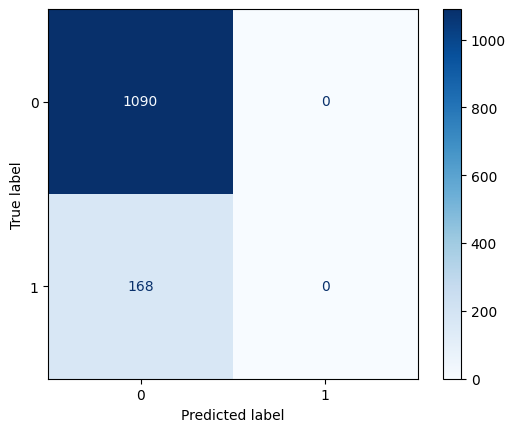

In [10]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 목적 함수 정의
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 2048),
        'max_depth': trial.suggest_int('max_depth', 5, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e2, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-5, 1e1, log=True),
        'max_bin': trial.suggest_int('max_bin', 10, 512),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'random_state': 42,
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(DI_X_train, DI_y_train, eval_set=[(DI_X_test, DI_y_test)])
    
    y_pred_proba = model.predict_proba(DI_X_test)[:, 1]
    auc = roc_auc_score(DI_y_test, y_pred_proba)
    
    return auc

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적의 하이퍼파라미터로 모델 학습
best_params = trial.params
DI_model = lgb.LGBMClassifier(**best_params)
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.8664546899841018
Model F1 Score: 0.0
Model AUC: 0.7120085190039318


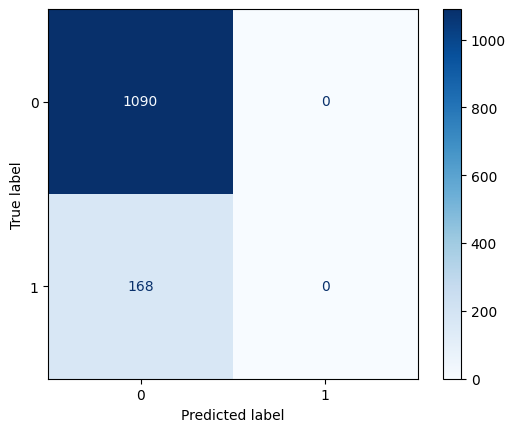

In [41]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 모델 초기화
DI_model = LGBMClassifier(
    n_estimators=1171,
    num_leaves=1352,
    max_depth=133,
    learning_rate=0.013047268869340142,
    min_child_samples=165,
    subsample=0.24314691590400292,
    colsample_bytree=0.19334614890476431,
    reg_alpha=5.901900488743287,
    reg_lambda=3.858355492244645e-05,
    min_split_gain=0.00045035353026440803,
    random_state=42,
    objective='binary',
    metric='auc',
    verbose=-1,
    boosting_type='gbdt'
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 제출

In [102]:
# 모델 구축
# IVF_model = CatBoostClassifier(
#     iterations=680,
#     depth=10,
#     learning_rate=0.01,
#     random_seed=42,
#     verbose=0
# )

# DI_model = CatBoostClassifier(
#     iterations=500,
#     depth=10,
#     learning_rate=0.01,
#     random_seed=42,
#     verbose=0
# )

# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [61]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('./code14_submit.csv', index=False, encoding='utf-8')

.